#### This notebook compares just active learning of classifier without topic model with random selection of documents

In [7]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics.cluster import rand_score
from scipy.sparse import vstack
import numpy as np
from sklearn.metrics import accuracy_score
import pandas as pd
from flask_app.utils.tools import purity_score
import random
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
import os

In [8]:
current_dir = os.getcwd()
topic_models_dir = os.path.dirname(current_dir)

In [9]:
data = pd.read_json('Topic_Models/Data/congressional_bill_train.json')
texts = list(data['text'])
labels = list(data['label'])
general_labels =list(data['label'])
sub_labels = list(data['sub_labels'])

vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(texts)

In [10]:
len(texts)

13041

In [11]:
from flask_app.classifier import Active_Learning

In [12]:
%%capture
def one_run():
    alto = Active_Learning(texts , None,  None, data, 'logreg', X_train_vectorized, len(texts), 0, data)
    labeled_idx = set()
    classifier1_acc = []
    classifier1 = SGDClassifier(loss="log_loss", penalty="l2", max_iter=1000, tol=1e-3, random_state=42, learning_rate="adaptive", eta0=0.1, validation_fraction=0.2)
    documents_track1, documents_track2 = None, None
    labels_track1, labels_track2 = [], []
    alto_acc = []
    general_labels1, general_labels2 = [], []
    purity1, purity2 = [], []
    rand1, rand2 = [], []
    nmi1, nmi2 = [], []

    for i in range(100):
        idx = random.randint(0, len(texts)-1)
        while idx in labeled_idx:
            idx = random.randint(0, len(texts)-1)
        
        labeled_idx.add(idx)
        if documents_track1 is None:
            documents_track1 = X_train_vectorized[idx]
        else:
            documents_track1 = vstack((documents_track1, X_train_vectorized[idx]))
        
        labels_track1.append(labels[idx])
        general_labels1.append(general_labels[idx])
        
        if len(np.unique(labels_track1)) >= 2:
            try:
                classifier1.partial_fit(documents_track1, labels_track1, classes=np.unique(labels_track1))
                # classifier1.fit(documents_track1, labels_track1)
                preds1 = classifier1.predict(X_train_vectorized)
                classifier1_acc.append(accuracy_score(labels, preds1))
            except:
                classifier1 = SGDClassifier(loss="log", penalty="l2", max_iter=1000, tol=1e-3, random_state=42, learning_rate="adaptive", eta0=0.1, validation_fraction=0.2)
                classifier1.partial_fit(documents_track1, labels_track1, classes=np.unique(labels_track1))
                # classifier1.fit(documents_track1, labels_track1)
                preds1 = classifier1.predict(X_train_vectorized)
                classifier1_acc.append(accuracy_score(labels, preds1))

            local_preds1 = classifier1.predict(documents_track1)
            purity1.append(purity_score(general_labels, preds1))
            rand1.append(rand_score(general_labels, preds1))
            nmi1.append(normalized_mutual_info_score(general_labels, preds1))


        '''
        ALTO part
        '''
        doc_id, score = alto.recommend_document(True)
        alto.label(doc_id, labels[doc_id])
        

        if documents_track2 is None:
            documents_track2 = X_train_vectorized[doc_id]
        else:
            documents_track2 = vstack((documents_track2, X_train_vectorized[doc_id]))

        labels_track2.append(labels[doc_id])
        general_labels2.append(general_labels[doc_id])

        if len(alto.classes) >= 2:
            alto_preds = alto.classifier.predict(X_train_vectorized)
            alto_acc.append(accuracy_score(labels, alto_preds))

            local_preds2 = alto.classifier.predict(documents_track2)
            purity2.append(purity_score(general_labels, alto_preds))
            rand2.append(rand_score(general_labels, alto_preds))
            nmi2.append(normalized_mutual_info_score(general_labels, alto_preds))
  

    return alto_acc, classifier1_acc, purity1, purity2, rand1, rand2, nmi1, nmi2



In [20]:
%%capture
acc1, acc2 = [], []
p1, p2 = [], []
r1, r2 = [], []
n1, n2 = [], []

for i in range(5):
    a, b, c, d, e, f, g, h = one_run()
#     print('{}, {}, {}, {}'.format(len(a), len(b), len(c), len(d)))
    acc1.append(a)
    acc2.append(b)
    p1.append(c)
    p2.append(d)
    r1.append(e)
    r2.append(f)
    n1.append(g)
    n2.append(h)


In [21]:
z = [i for i in range(2, 101)]

In [22]:
import matplotlib.pyplot as plt
def plot(acc1, acc2, acc_type):
    plt.plot(z, acc1, label='alto')
    plt.plot(z, acc2, label='normal')
    plt.xlabel('Num docs labeled')
    plt.ylabel(acc_type)
    plt.title('{} vs. N'.format(acc_type))
    plt.legend()
    plt.grid(True)
    plt.show()

In [17]:
def plot_every_interval(acc1, acc2, acc_type, interval):
    window_size = interval

    # Apply moving average
    
    smoothed_accuracy1 = np.convolve(acc1, np.ones(window_size)/window_size, mode='valid')
    smoothed_accuracy2 = np.convolve(acc2, np.ones(window_size)/window_size, mode='valid')
    X = list(range(1, len(smoothed_accuracy1)+1))
    plt.plot(X, smoothed_accuracy1, label='alto')
    plt.plot(X, smoothed_accuracy2, label='normal')
    plt.xlabel('Num docs labeled')
    plt.ylabel(acc_type)
    plt.title('{} vs. N'.format(acc_type))
    plt.legend()
    plt.grid(True)
    plt.show()


In [23]:
for ele in acc2:
    print(len(ele))

99
99
99
99
99


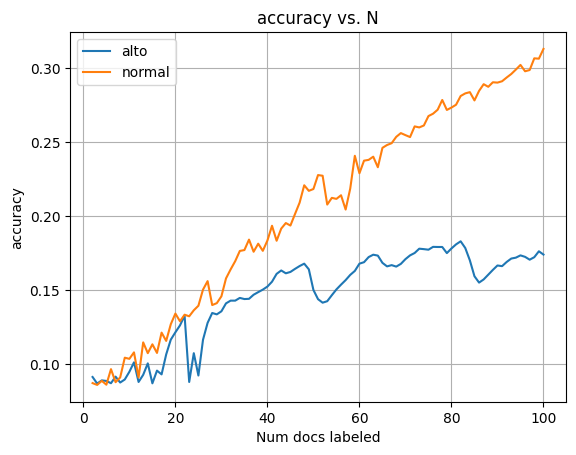

In [24]:
classifier1_acc = np.median(acc1, axis = 0)
alto_acc = np.median(acc2, axis = 0)
plot(classifier1_acc,alto_acc, 'accuracy')

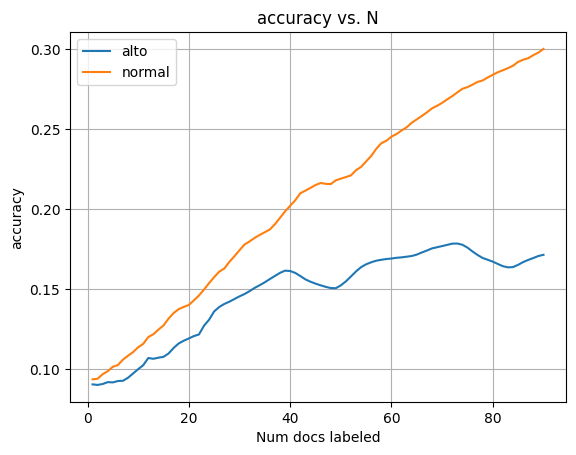

In [25]:
plot_every_interval(classifier1_acc,alto_acc, 'accuracy', 10)

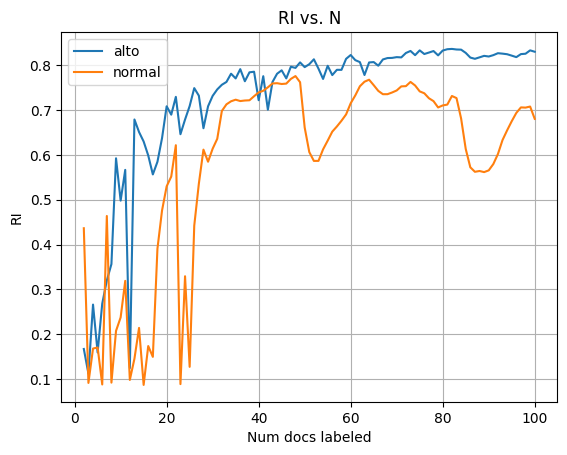

In [26]:
r1_acc = np.median(r1, axis = 0)
r2_acc = np.median(r2, axis = 0)
plot(r1_acc, r2_acc, 'RI')

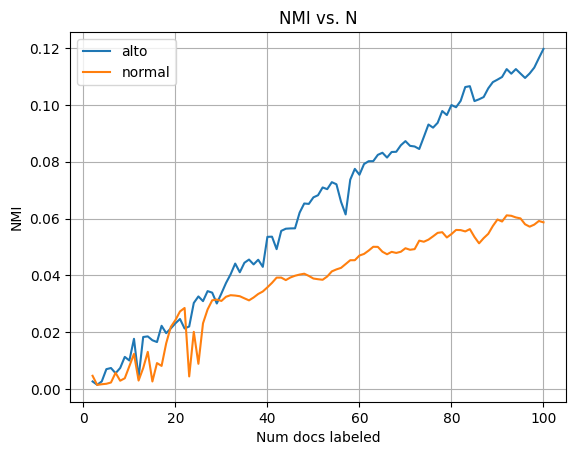

In [27]:
n1_acc = np.median(n1, axis = 0)
n2_acc = np.median(n2, axis = 0)
plot(n1_acc, n2_acc, 'NMI')

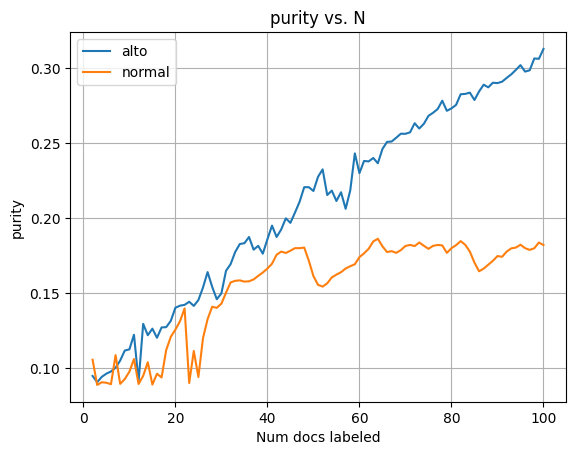

In [28]:
p1_acc = np.median(p1, axis = 0)
p2_acc = np.median(p2, axis = 0)
plot(p1_acc, p2_acc, 'purity')